# Climate extremes insights from $E^3CI$

![alt text](data/logo_e3c_int.svg "European Extreme Events Climate Index")

The aim of the exercise proposed in this notebook is the extraction of insights from $E^3CI$, a dataset specifically designed to describe extreme events.

First, exploratory data analysis of the dataset will be carried out to highlight some spatial and temporal evidences.
Then, a clustering modeling will be applied in order to derive further climate patterns.

## Introduction

The *European Extreme Events Climate Index* ($E^3CI$) is a tool for the monitoring of the occurrence and magnitude of extreme weather events.
It is composed by a set of components related to different perils evaluated at a monthly scale and a composite index resuming the impact of components as a whole.

The E3CI is a project funded by IFAB (https://www.ifabfoundation.org/), the International Foundation Big Data and Artificial Intelligence for Human Development, and implemented by Leithà (https://leitha.eu/), the insurtech company of the Unipol Group, and the Euro-Mediterranean Center on Climate Change (CMCC) (https://www.cmcc.it/).

The computation is based on ERA5 data produced by ECMWF and distributed by the Copernicus Climate Change Service (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview).

Each component of $E^3CI$  has been designed in order to asses the potential occurence of an extreme event based on its frequency anomaly with respect to a historical baseline referred to the period 1981-2010.

Here follows a brief description of $E^3CI$ components:

1. **Heat stress**: this component measures the anomaly of the number of days in the month with maximum hourly temperature above time-dependent thresholds with respect to the expected number of exceedings based on historical baseline.

2. **Cold stress**: this component measures the anomaly of the number of days in the month with minimum hourly temperature below time-dependent thresholds with respect to the expected number of exceedings based on historical baseline.

3. **Extreme precipitation**: this component measures the anomaly of the monthly precipitation fraction due to heavy rain with respect to that estimated based on the historical baseline for that month of the year. 

4. **Drought**: the drought component is given by the Standardized Precipitation Index (SPI)[2].

5. **Extreme wind**: this component measures the anomaly of the *Local Loss Index*[1] with respect to that estimated based on the historical baseline for that month of the year. 

A detailed description of $E^3CI$ can be found here: https://www.ifabfoundation.org/e3ci/.

#### References
* [1]: *Donat, Markus G., et al. "Benefits and limitations of regional multi-model ensembles for storm loss estimations." Climate Research 44.2-3 (2010): 211-225.*
* [2]: *McKee, Thomas B., Nolan J. Doesken, and John Kleist. "The relationship of drought frequency and duration to time scales." Proceedings of the 8th Conference on Applied Climatology. Vol. 17. No. 22. 1993.*

## Table of contents

* [1. Data reading and preparation](#section_1)
* [2. Exploratory data analysis](#section_2)
    * [2.1 Decades trends](#section_21)
    * [2.2 Spatial trends](#section_22)
    * [2.3 Seasonality checks](#section_23)
    * [2.4 Known events](#section_24)
* [3. Clustering](#section_3)
    * [3.1. Time series clustering](#section_31)
    * [3.2. Clustering on average components](#section_32)

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
<tr>
<th>Run the tutorial via free cloud platforms: </th>
<th><a href="https://colab.research.google.com/github/neivnova/mooc-machine-learning-weather-climate/blob/main/tier_3/ocean_climate/e3ci/E3CI_Lab_pf.ipynb">
<img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
</tr>
</table>

In [1]:
%%bash
mkdir data
wget https://raw.githubusercontent.com/ecmwf-projects/mooc-machine-learning-weather-climate/main/tier_3/ocean_climate/e3ci/requirements.txt -O requirements.txt
wget https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/ocean_climate/e3ci/data/e3ci_dataset_workshop.xlsx?raw=true -O data/e3ci_dataset_workshop.xlsx
wget https://raw.githubusercontent.com/ecmwf-projects/mooc-machine-learning-weather-climate/main/tier_3/ocean_climate/e3ci/data/europe.geojson -O data/europe.geojson

--2023-04-17 20:32:37--  https://raw.githubusercontent.com/ecmwf-projects/mooc-machine-learning-weather-climate/main/tier_3/ocean_climate/e3ci/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82 [text/plain]
Saving to: ‘requirements.txt’

     0K                                                       100% 3.48M=0s

2023-04-17 20:32:37 (3.48 MB/s) - ‘requirements.txt’ saved [82/82]

--2023-04-17 20:32:37--  https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/ocean_climate/e3ci/data/e3ci_dataset_workshop.xlsx?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github

In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.1 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=91abe8a8440a3f0f2d9b6d77eddb93d83bc1647a9e7713e292c5d68ae6c15ed9
  Stored in directory: /root/.cache/pip/wheels/d5/b2/a9/590d15767d34955f20a9a033e8db973b79cb5672d95790c0a9
Successfully built sklearn


In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

<a id="section_1"></a>
## 1. Data reading and preparation

In this tutorial we will use an $E^3CI$ dataset aggregated at country level.

In [5]:
data = pd.read_excel('./data/e3ci_dataset_workshop.xlsx', index_col=0, header=[0, 1])

In [45]:
data.head(5)

Country        Albania                                                         \
Type       Cold stress   Drought      E3CI Extreme precipitation Extreme wind   
Month                                                                           
2011-01-01   -0.078213 -1.371647 -0.465653             -0.562125    -0.555938   
2011-02-01   -0.759092 -0.037781 -0.249911             -0.610225    -0.492050   
2011-03-01   -0.179992  0.726726  0.117410             -0.484392     0.209930   
2011-04-01   -0.481207  2.005130  0.180082             -0.570242     0.232686   
2011-05-01    0.059924  0.855416  0.029912              0.022204    -0.204063   

Country                    Andorra                                            \
Type       Heat stress Cold stress   Drought      E3CI Extreme precipitation   
Month                                                                          
2011-01-01    0.239657   -0.053328  1.337466  0.083756             -0.798264   
2011-02-01    0.649591   -0.894044  1.449578 -0.043732             -0.627979   
2011-03-01    0.314778   -1.004709  0.495754 -0.186831              0.473449   
2011-04-01   -0.285955   -0.990662  0.242866  0.464269             -0.727383   
2011-05-01   -0.583920   -0.407253  0.190049  0.085589             -0.571230   

Country     ...   Ukraine                                                 \
Type        ...      E3CI Extreme precipitation Extreme wind Heat stress   
Month       ...                                                            
2011-01-01  ... -0.469652             -0.046809    -0.533979   -0.494852   
2011-02-01  ...  0.475130             -0.337375     2.331151   -0.442257   
2011-03-01  ...  0.099113             -0.525370    -0.195610   -0.177971   
2011-04-01  ...  0.531136             -0.339759     2.341202   -0.325766   
2011-05-01  ...  0.044096             -0.309617    -0.489038   -0.039937   

Country    United Kingdom                                            \
Type          Cold stress   Drought      E3CI Extreme precipitation   
Month                                                                 
2011-01-01       0.384620  1.093454  0.060296             -0.370887   
2011-02-01      -0.702035  0.570153  0.183535              0.310547   
2011-03-01      -0.244465  0.457211 -0.060049             -0.541279   
2011-04-01      -1.026022  1.392781  0.587800             -0.191093   
2011-05-01      -0.633168  1.382846  1.339010              0.783808   

Country                              
Type       Extreme wind Heat stress  
Month                                
2011-01-01    -0.507094   -0.298615  
2011-02-01     0.118383    0.620629  
2011-03-01    -0.324676    0.352963  
2011-04-01    -0.460379    3.223710  
2011-05-01     4.736411    0.425156  

[5 rows x 276 columns]

In [6]:
countries = gpd.read_file('./data/europe.geojson')

It will be useful to consider whether each component value exceeded a warning threshold here considered equal to 1:

In [7]:
threshold = 1
data_gt1 = data.apply(lambda x: x > threshold)

<a id="section_2"></a>
## 2. Exploratory data analysis

In [8]:
components = ['Heat stress', 'Cold stress', 'Drought', 'Extreme precipitation', 'Extreme wind']

In order to perform some exploration on data let's select a specific country. Feel free to change it in order to explore $E^3CI$ on your country of interest.

In [79]:
country_name = 'France'

In [80]:
data_country = data[country_name]
data_country_gt1 = data_gt1[country_name]

<a id="section_21"></a>
### 2.1 Decades trends

Since $E^3CI$ accounts for a historical baseline referred to the period 1981-2010, we expect to observe average values close to zero on the same period, while larger values are expected corresponding to recent years due to climate change effets:

In [81]:
data_country.loc[slice(None, datetime(2011, 1, 1))].mean()

Type
Cold stress              0.043388
Drought                 -0.449825
E3CI                    -0.111583
Extreme precipitation   -0.359696
Extreme wind            -0.551287
Heat stress              0.759503
dtype: float64

In [82]:
data_country.loc[slice(datetime(2011, 1, 1), None)].mean()

Type
Cold stress             -0.341022
Drought                  0.225887
E3CI                     0.114379
Extreme precipitation    0.043591
Extreme wind             0.057509
Heat stress              0.585929
dtype: float64

Indeed, some magnitude of increasing of extremes is shown by **Extreme precipitation**, **Extreme wind**, **Heat stress** components and the composite **E3CI** index.

Now, let's aggregate by decade and plot the average components values and exceedings counts

In [48]:
decade_idxs = pd.cut(data_country.index.year, [1980, 1990, 2000, 2010, 2020])

In [49]:
decade_idxs

[(2010, 2020], (2010, 2020], (2010, 2020], (2010, 2020], (2010, 2020], ..., NaN, NaN, NaN, NaN, NaN]
Length: 143
Categories (4, interval[int64, right]): [(1980, 1990] < (1990, 2000] < (2000, 2010] < (2010, 2020]]

In [14]:
decade_gt1 = data_country_gt1.groupby(decade_idxs).sum()

#### Number of exceedings

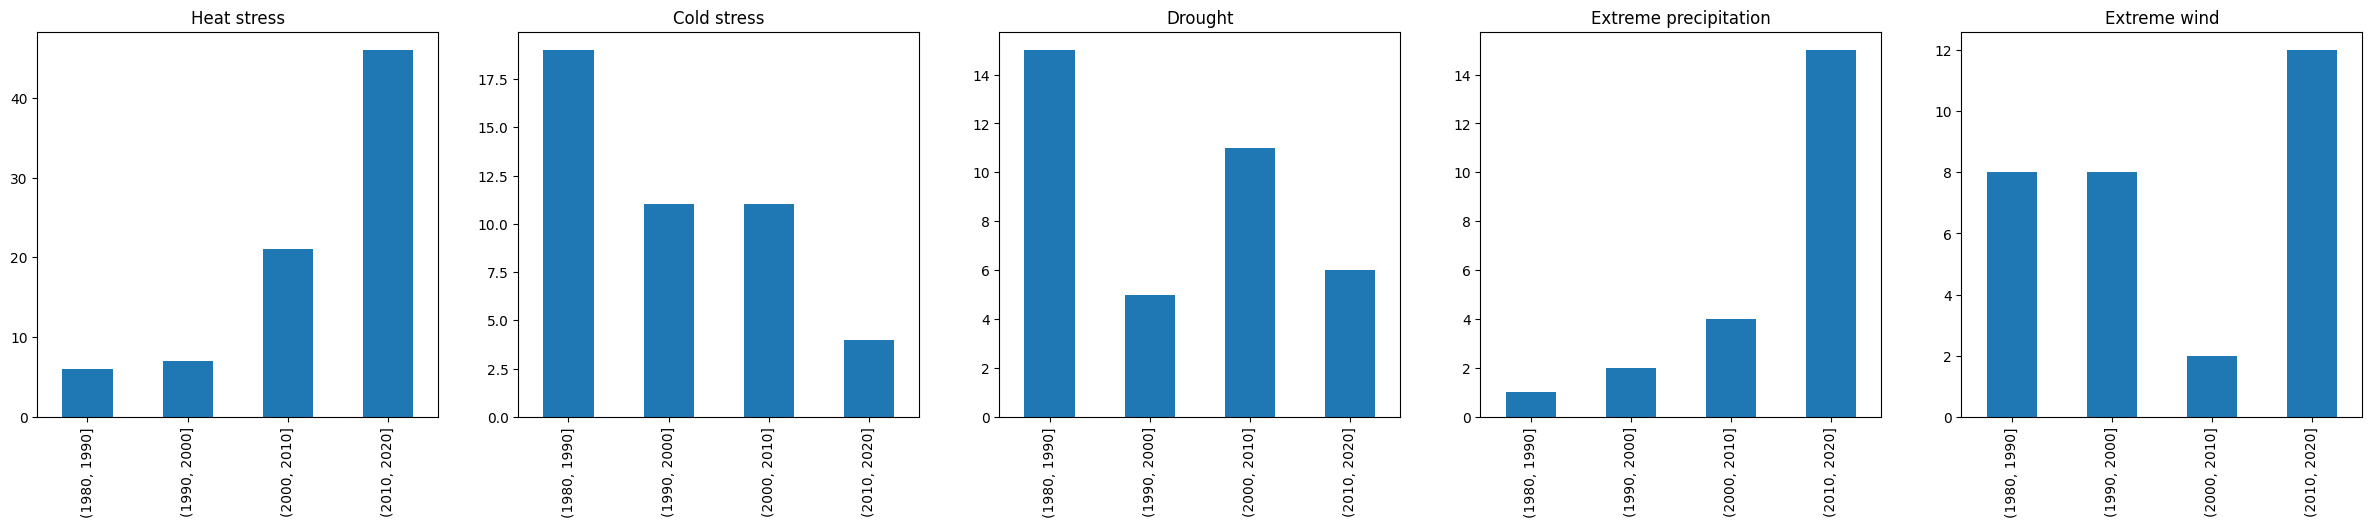

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for component, ax in zip(components, axes):
    decade_gt1[component].plot.bar(ax=ax)
    ax.set_title(component)

The following analyses will consider only data outside the baseline period.

In [50]:
data = data.loc[slice(datetime(2011, 1, 1), None)]
data_country = data_country.loc[slice(datetime(2011, 1, 1), None)]

data_gt1 = data_gt1.loc[slice(datetime(2011, 1, 1), None)]
data_country_gt1 = data_country_gt1.loc[slice(datetime(2011, 1, 1), None)]

<a id="section_22"></a>
### 2.2 Spatial trends

In order to visualize spatial patterns we plot maps of country average values.

In [51]:
country_agg_gt1 = data_gt1.sum()

#### Number of exceedings

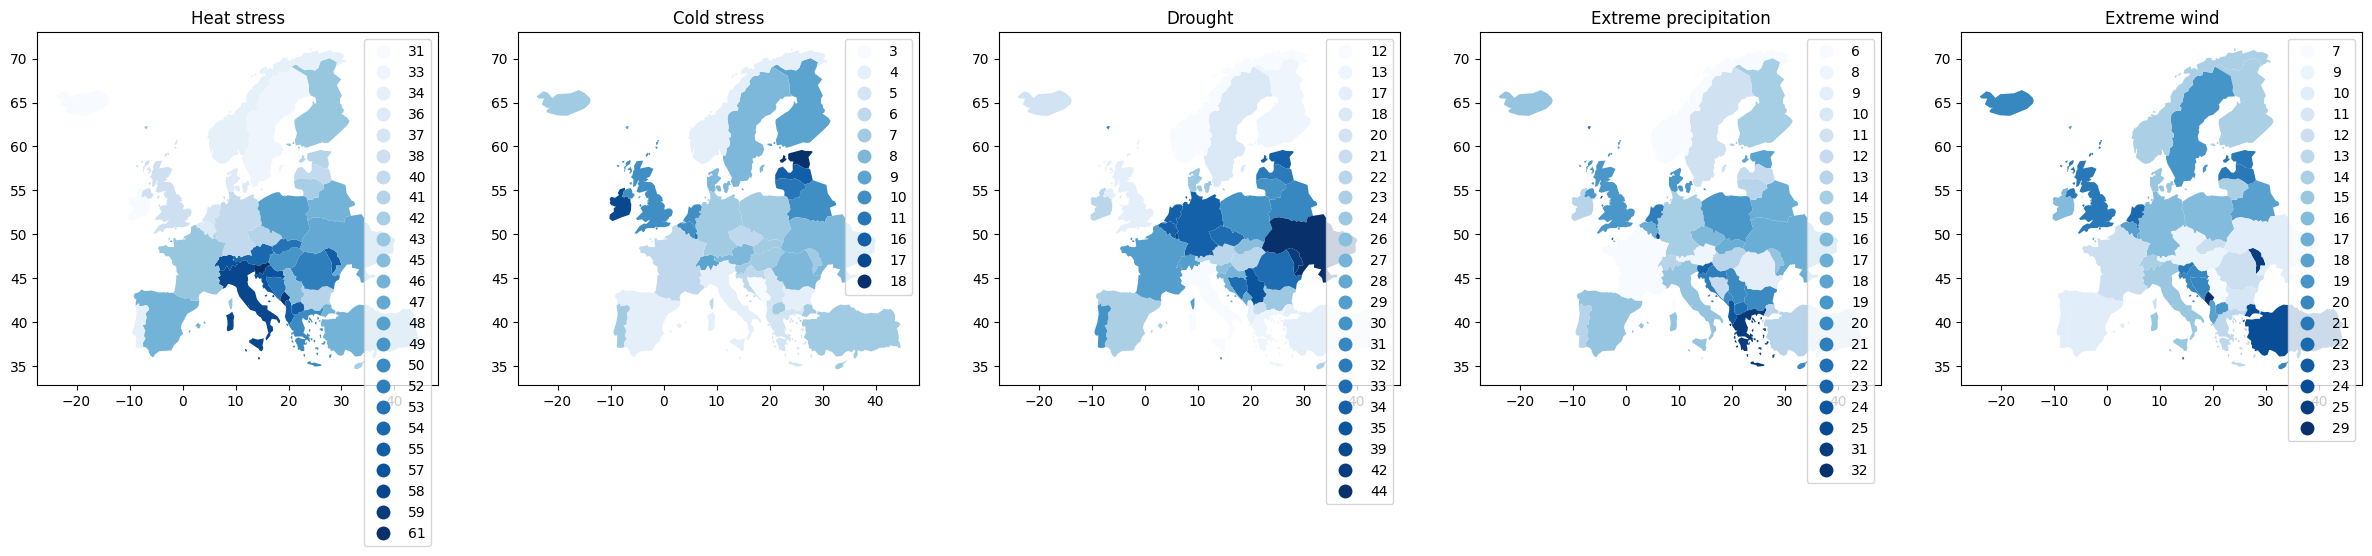

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for component, ax in zip(components, axes):
    country_data = countries.join(country_agg_gt1.loc[:, component].rename(component), on='NAME_ENGL', how='inner')
    country_data.plot(column=component, ax=ax, legend=True, cmap='Blues')
    ax.set_title(component)

<a id="section_23"></a>
### 2.3 Seasonality checks

In [53]:
seasons = {1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM', 6: 'JJA', 
            7: 'JJA', 8: 'JJA', 9: 'SON', 10: 'SON', 11: 'SON', 12: 'DJF'}
data_gt1['Season'] = data_gt1.index.month.map(seasons)

In [54]:
season_agg_gt1 = data_gt1.groupby('Season').sum().reindex(['DJF','MAM','JJA','SON'])

#### Number of exceedings

In [55]:
country = 'Germany'

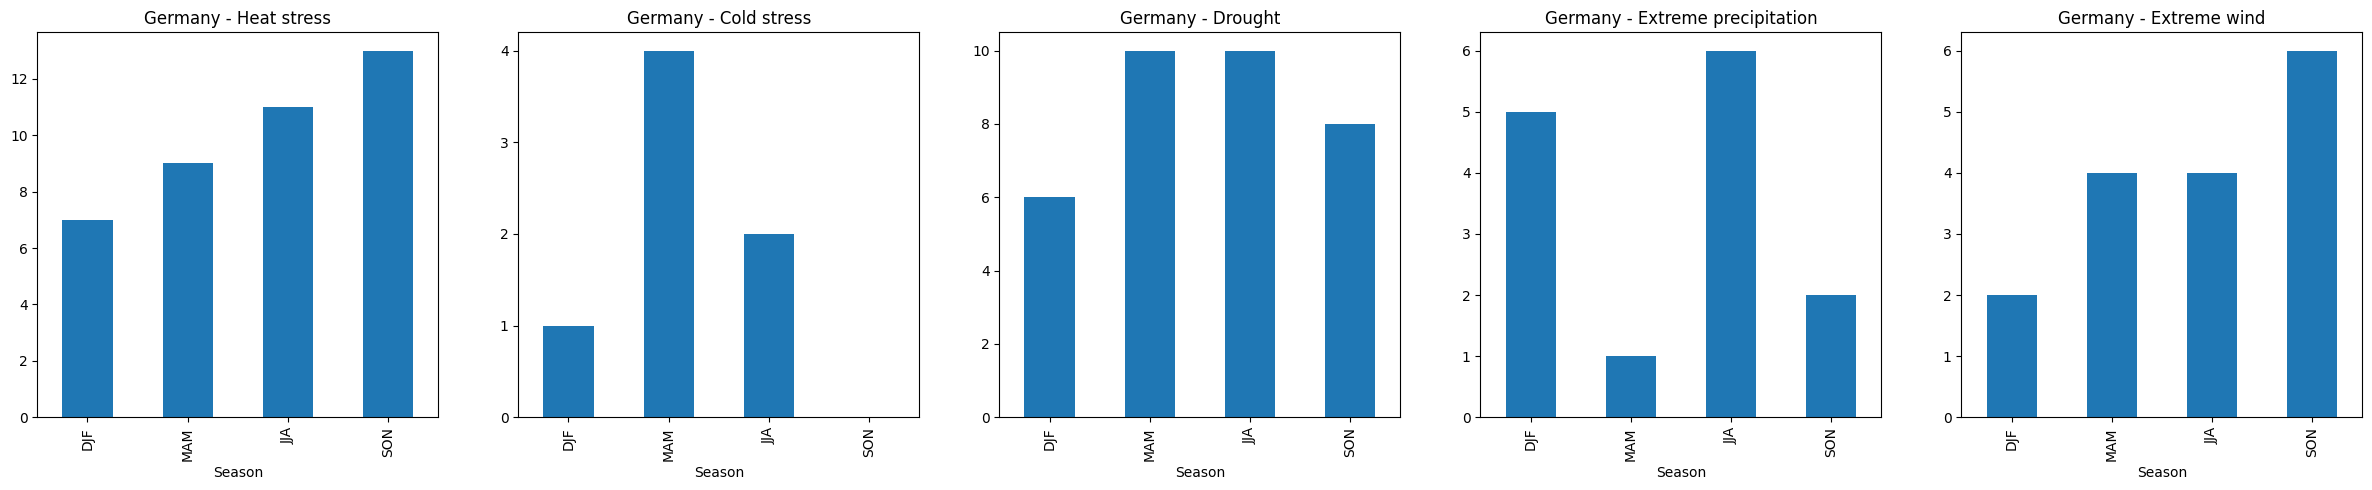

In [56]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for component, ax in zip(components, axes):
    season_agg_gt1[country][component].plot.bar(ax=ax)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f'{country} - {component}')

<a id="section_24"></a>
### 2.4 Known events

The [European State of the Climate 2021](https://climate.copernicus.eu/sites/default/files/2022-07/ESOTCsummary2021_static.pdf) highlights following climate extremes registered during 2021:

Peril | Countries | Months
---|---|---
Heat stress|Italy, Greece, Spain, Turkey| 6, 7, 8
Extreme precipitation|Belgium, Germany, Luxembourg, Netherlands|7

In [57]:
data_gt1[['Italy', 'Spain', 'Greece', 'Turkey']].xs('Heat stress', axis=1, level=1).loc[
    [datetime(2021, 6, 1), datetime(2021, 7, 1), datetime(2021, 8, 1)]
]

Country,Italy,Spain,Greece,Turkey
Month,,,,
2021-06-01,True,False,True,False
2021-07-01,False,False,True,True
2021-08-01,True,False,True,False


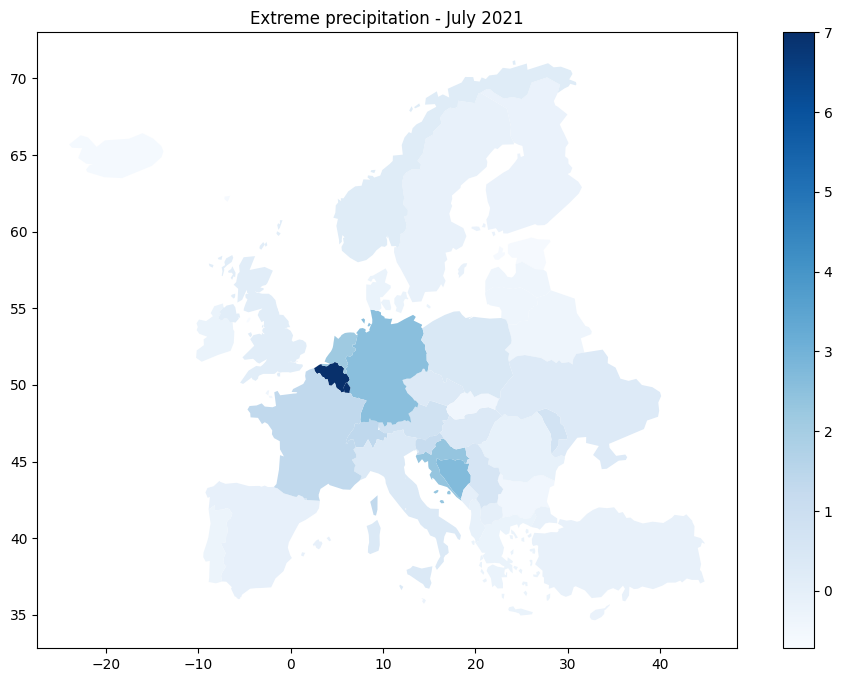

In [58]:
component = 'Extreme precipitation'
event_data = data.xs(component, axis=1, level=1).loc[datetime(2021, 7, 1)].rename(component)

fig, ax = plt.subplots(figsize=(12,8))
country_data = countries.join(event_data, on='NAME_ENGL', how='inner')
country_data.plot(column=component, ax=ax, legend=True, cmap='Blues',vmax=7)
ax.set_title(f'{component} - July 2021')
fig.show()

In [59]:
event_data[['Belgium', 'Germany', 'Luxembourg', 'Netherlands']]

Country
Belgium         7.201934
Germany         2.551651
Luxembourg     13.211065
Netherlands     2.147316
Name: Extreme precipitation, dtype: float64

<a id="section_3"></a>
## 3. Clustering

<a id="section_31"></a>
### 3.1 Time series clustering

A clustering of time series allows to identify groups of countries with similar time patterns of extreme occurrences. More information about clustering can be found in the following links:

* https://en.wikipedia.org/wiki/Cluster_analysis
* https://matteucci.faculty.polimi.it/Clustering/tutorial_html/index.html.

Here, we will apply the `TimeSeriesKMeans` module provided by the [tslearn](https://tslearn.readthedocs.io/en/stable/index.html) library in order to perform a K-means on the **Heat stress** component countries time series.

In order to select an appropriate number of clusters we adopt the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

In [60]:
time_series_data = data.xs('Heat stress', axis=1, level=1, drop_level=False).T

In [64]:
time_series_data.head(5)

,Month,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,...,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01
Country,Type,,,,,,,,,,,,,,,,,,,,,
Albania,Heat stress,0.239657,0.649591,0.314778,-0.285955,-0.583920,-0.344839,1.095647,0.790822,3.156620,-0.978817,...,0.424439,-0.670417,0.276506,0.923501,3.314060,2.769784,0.650210,0.722549,0.966223,1.198294
Andorra,Heat stress,0.427142,0.218282,-0.407717,4.306359,0.977677,-0.286635,-0.908258,0.313846,1.824916,0.706268,...,1.111252,-0.407717,0.215886,2.821296,3.282779,4.137620,0.776896,0.010082,4.117899,0.976574
Austria,Heat stress,0.867851,0.317335,0.682158,2.080895,0.143827,-0.206857,0.175532,1.358150,1.986823,0.376099,...,0.698529,0.348286,0.112995,1.352682,1.861854,1.419133,1.186873,-0.048691,2.616959,0.535477
Belarus,Heat stress,-0.666786,-0.390942,-0.443999,-0.554556,-0.136890,1.041382,0.925322,-0.142758,0.155967,-0.464704,...,1.163017,0.146319,-0.674315,-0.883724,1.360852,0.100694,3.107710,-1.133247,1.542794,0.725671
Belgium,Heat stress,0.655558,-0.039208,0.272911,3.242416,0.412911,0.499968,-0.853704,-0.690709,1.241129,0.972966,...,0.679305,1.078249,-0.007852,0.865486,0.693592,0.207866,2.312728,0.858235,3.270697,0.672105


In [61]:
location_list = time_series_data.index.get_level_values('Country')

In [62]:
data_array = np.array(time_series_data.values)

In [63]:
inertia = []

K = range(1,50)
for k in tqdm(K):
    model = TimeSeriesKMeans(n_clusters=k)
    km = model.fit(data_array)
    inertia.append(km.inertia_)

100%|██████████| 49/49 [00:01<00:00, 24.91it/s]


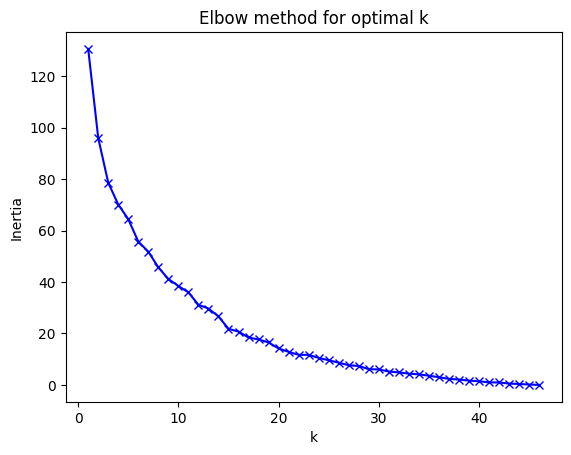

In [30]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal k')
plt.show()

In [65]:
n_clusters = 17

In [66]:
data_array = np.array(time_series_data.values)

model = TimeSeriesKMeans(n_clusters=n_clusters)
model.fit(data_array)

TimeSeriesKMeans(n_clusters=17)

In [67]:
y = model.predict(data_array)

In [68]:
y

array([ 2,  0,  9,  4, 14,  2,  2,  9,  8,  1, 14,  4, 16,  6,  0, 14,  2,
       13,  9,  7,  3,  3,  9, 13,  5,  4,  4, 14, 11, 12,  2, 14,  2, 15,
        1, 10, 12,  2,  1,  9, 10, 15,  0,  8, 12,  3])

In [69]:
country_cluster = dict(zip(location_list,y))
europe = countries[countries['NAME_ENGL'].isin(location_list)]
europe['cluster'] = europe.apply(lambda row: country_cluster[row['NAME_ENGL']], axis=1)

In [35]:
europe.explore(column='cluster', 
               legend=True, 
               categorical=True, 
               popup=True,
               cmap="Paired",
               style_kwds=dict(color="black"))

<a id="section_32"></a>
### 3.2 Clustering on average components

# New Section

We want to find clusters of Countries affected by extremes with similar proportions of impacts related to different components.

In [70]:
data_agg_pivot = data.stack().mean(level=1, skipna=True).T
data_agg_pivot = data_agg_pivot.div(data_agg_pivot.sum(axis=1), axis=0)

In [71]:
data_agg_pivot.drop('E3CI', axis=1, inplace=True)

In [72]:
data_array = np.array(data_agg_pivot.values)
inertia = []

K = range(1,40)
for k in tqdm(K):
    model = KMeans(n_clusters=k)
    km = model.fit(data_agg_pivot)
    inertia.append(km.inertia_)

100%|██████████| 39/39 [00:01<00:00, 21.86it/s]


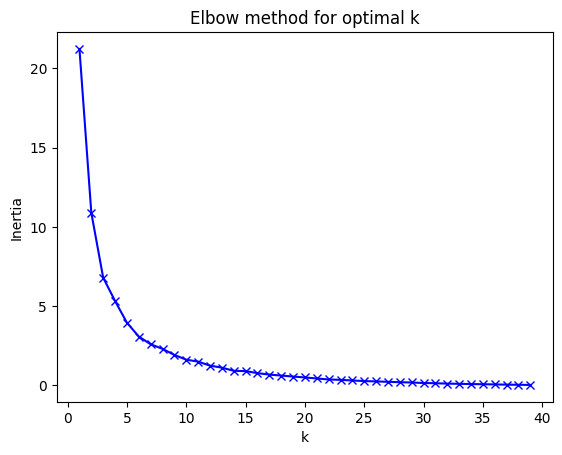

In [73]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal k')
plt.show()

In [74]:
n_clusters = 6

In [75]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_agg_pivot)

In [76]:
data_agg_pivot['cluster'] = kmeans.labels_

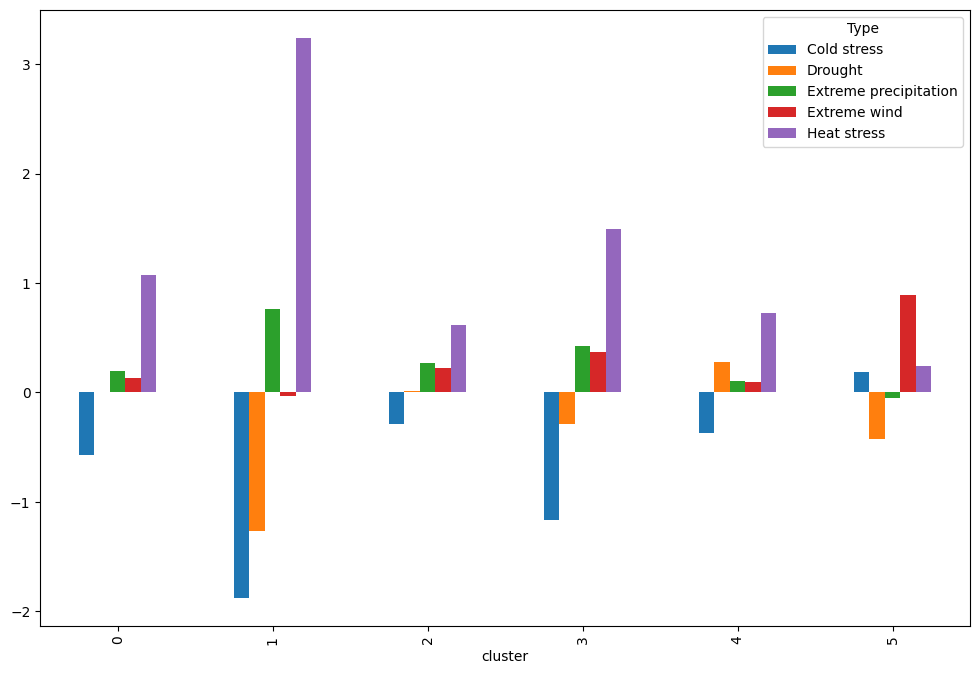

In [77]:
fig, ax = plt.subplots(figsize=(12,8))
means = data_agg_pivot.groupby('cluster').mean()
means.plot.bar(ax=ax)
fig.show()

In [78]:
clustering = countries.join(data_agg_pivot, on='NAME_ENGL', how='inner')
clustering.explore(column='cluster', cmap="Paired", categorical=True)